# Timing Data

In [1]:
from time_solvers import timed_trials, plot_solver_run_times
import numpy as np

In [2]:
from gillespy2 import StochKitSolver, NumPySSASolver, OptimizedSSASolver, SSACSolver, BasicTauLeapingSolver, BasicTauHybridSolver
from gillespy2.example_models import Example, Trichloroethylene, MichaelisMenten, Schlogl
modelList = [Example(), Trichloroethylene(), MichaelisMenten(), Schlogl()]
solverList = [ StochKitSolver, NumPySSASolver, OptimizedSSASolver, SSACSolver, BasicTauLeapingSolver, BasicTauHybridSolver]

In [3]:
import os
os.environ['STOCHKIT_HOME'] = "/mnt/c/Users/seanm/OneDrive/Documents/Research/StochKit"

In [4]:
trajectories = [2**i for i in range(11)]
timing_data = timed_trials(modelList, solverList, trajectories, number_trials=30,output_file='timing_data.pkl')

Model: Example, Solver: StochKitSolver, Trajectories: 1: 100%|██████████| 30/30 [00:08<00:00,  3.59it/s]
Model: Example, Solver: StochKitSolver, Trajectories: 2: 100%|██████████| 30/30 [00:09<00:00,  3.15it/s]
Model: Example, Solver: StochKitSolver, Trajectories: 4: 100%|██████████| 30/30 [00:10<00:00,  2.94it/s]
Model: Example, Solver: StochKitSolver, Trajectories: 8: 100%|██████████| 30/30 [00:13<00:00,  2.40it/s]
Model: Example, Solver: StochKitSolver, Trajectories: 16: 100%|██████████| 30/30 [00:15<00:00,  1.95it/s]
Model: Example, Solver: StochKitSolver, Trajectories: 32: 100%|██████████| 30/30 [00:24<00:00,  1.15it/s]
Model: Example, Solver: StochKitSolver, Trajectories: 64: 100%|██████████| 30/30 [00:40<00:00,  1.29s/it]
Model: Example, Solver: StochKitSolver, Trajectories: 128: 100%|██████████| 30/30 [01:11<00:00,  2.35s/it]
Model: Example, Solver: StochKitSolver, Trajectories: 256: 100%|██████████| 30/30 [02:09<00:00,  4.29s/it]
Model: Example, Solver: StochKitSolver, Trajecto

Model: Trichloroethylene, Solver: StochKitSolver, Trajectories: 256: 100%|██████████| 30/30 [02:31<00:00,  5.04s/it]
Model: Trichloroethylene, Solver: StochKitSolver, Trajectories: 512: 100%|██████████| 30/30 [04:52<00:00,  9.53s/it]
Model: Trichloroethylene, Solver: StochKitSolver, Trajectories: 1024: 100%|██████████| 30/30 [09:41<00:00, 19.90s/it]
Model: Trichloroethylene, Solver: NumPySSASolver, Trajectories: 1: 100%|██████████| 30/30 [00:01<00:00, 25.29it/s]
Model: Trichloroethylene, Solver: NumPySSASolver, Trajectories: 2: 100%|██████████| 30/30 [00:02<00:00, 12.29it/s]
Model: Trichloroethylene, Solver: NumPySSASolver, Trajectories: 4: 100%|██████████| 30/30 [00:05<00:00,  6.49it/s]
Model: Trichloroethylene, Solver: NumPySSASolver, Trajectories: 8: 100%|██████████| 30/30 [00:09<00:00,  3.27it/s]
Model: Trichloroethylene, Solver: NumPySSASolver, Trajectories: 16: 100%|██████████| 30/30 [00:18<00:00,  1.66it/s]
Model: Trichloroethylene, Solver: NumPySSASolver, Trajectories: 32: 100%

Model: Michaelis_Menten, Solver: NumPySSASolver, Trajectories: 1: 100%|██████████| 30/30 [00:01<00:00, 15.76it/s]
Model: Michaelis_Menten, Solver: NumPySSASolver, Trajectories: 2: 100%|██████████| 30/30 [00:04<00:00,  7.37it/s]
Model: Michaelis_Menten, Solver: NumPySSASolver, Trajectories: 4: 100%|██████████| 30/30 [00:07<00:00,  4.04it/s]
Model: Michaelis_Menten, Solver: NumPySSASolver, Trajectories: 8: 100%|██████████| 30/30 [00:14<00:00,  2.00it/s]
Model: Michaelis_Menten, Solver: NumPySSASolver, Trajectories: 16: 100%|██████████| 30/30 [00:29<00:00,  1.03it/s]
Model: Michaelis_Menten, Solver: NumPySSASolver, Trajectories: 32: 100%|██████████| 30/30 [00:58<00:00,  1.94s/it]
Model: Michaelis_Menten, Solver: NumPySSASolver, Trajectories: 64: 100%|██████████| 30/30 [01:56<00:00,  3.88s/it]
Model: Michaelis_Menten, Solver: NumPySSASolver, Trajectories: 128: 100%|██████████| 30/30 [03:50<00:00,  7.68s/it]
Model: Michaelis_Menten, Solver: NumPySSASolver, Trajectories: 256: 100%|██████████

Model: Schlogl, Solver: NumPySSASolver, Trajectories: 16: 100%|██████████| 30/30 [00:04<00:00,  6.24it/s]
Model: Schlogl, Solver: NumPySSASolver, Trajectories: 32: 100%|██████████| 30/30 [00:09<00:00,  3.13it/s]
Model: Schlogl, Solver: NumPySSASolver, Trajectories: 64: 100%|██████████| 30/30 [00:18<00:00,  1.59it/s]
Model: Schlogl, Solver: NumPySSASolver, Trajectories: 128: 100%|██████████| 30/30 [00:37<00:00,  1.25s/it]
Model: Schlogl, Solver: NumPySSASolver, Trajectories: 256: 100%|██████████| 30/30 [01:14<00:00,  2.49s/it]
Model: Schlogl, Solver: NumPySSASolver, Trajectories: 512: 100%|██████████| 30/30 [02:30<00:00,  5.00s/it]
Model: Schlogl, Solver: NumPySSASolver, Trajectories: 1024: 100%|██████████| 30/30 [05:02<00:00, 10.11s/it]
Model: Schlogl, Solver: CythonSSASolver, Trajectories: 1: 100%|██████████| 30/30 [00:00<00:00, 374.33it/s]
Model: Schlogl, Solver: CythonSSASolver, Trajectories: 2: 100%|██████████| 30/30 [00:00<00:00, 213.71it/s]
Model: Schlogl, Solver: CythonSSASolver

In [5]:
#Ideally, we can run the timed tests once and save the results for later in a .pkl file
import pickle
with open('timing_data.pkl', 'rb') as f:
    timing_data = pickle.load(f)
    
%matplotlib inline
styles = {
    'StochKitSolver' : 'r*-',
    'SSACSolver' : 'g*-',
    'CythonSSASolver' : 'b*-',
    'NumPySSASolver' : 'k*-',
    'BasicTauHybridSolver' : 'y*-',
    'BasicTauLeapingSolver' : 'm*-'
}

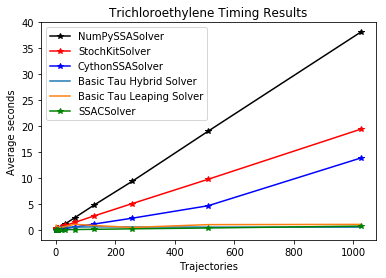

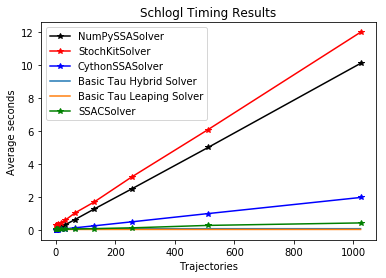

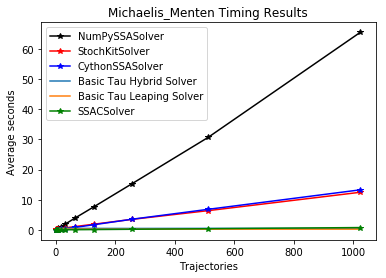

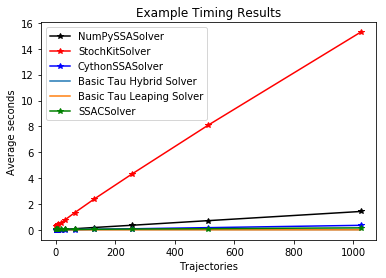

In [6]:
plot_solver_run_times(timing_data, line_styles=styles)

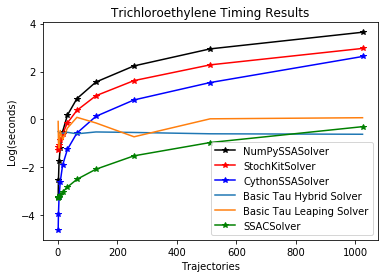

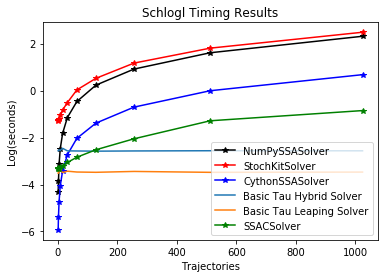

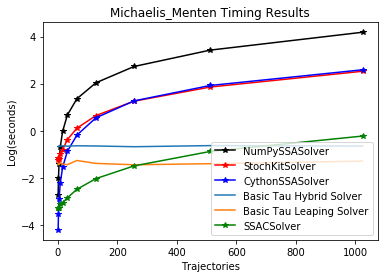

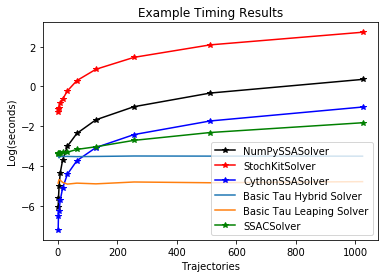

In [7]:
plot_solver_run_times(timing_data, line_styles=styles, ylabel='Log(seconds)', transformation=np.log)

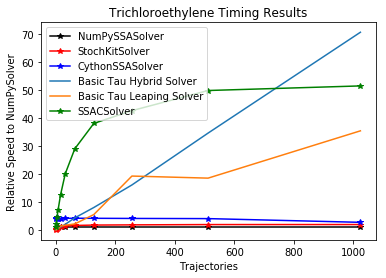

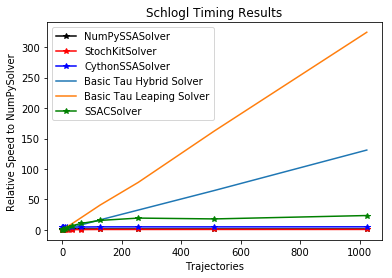

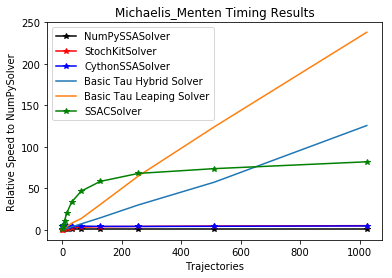

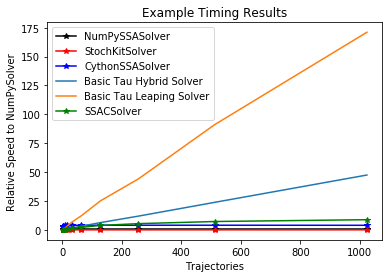

In [8]:
plot_solver_run_times(timing_data, line_styles=styles, ylabel='Relative Speed to NumPySolver', baseline_solver_name=NumPySSASolver.name)